# 2. Carga y preparación de datos para entrenamiento de modelos

Se harán dos modificaciones sobre el dataset original:
1. El dataset original contiene el tiempo relativo en segundos. Se asignará un tiempo inicial arbitrario para poder hacer búsquedas por intervalo de tiempo.
2. Se agregará una columna con un identificador artificial utilizando el número de fila del CSV para luego separar el dataset en entrenamiento y validación utilizando este identificador.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

In [2]:
DATASET_PATH="/data/credit_fraud/"
DATASET_ORIGINAL_FILENAME_PATH = DATASET_PATH+"creditcard.csv"
DATASET_MODIFIED_FILENAME_PATH = DATASET_PATH+"creditcard_mod.csv"

In [3]:
# Se elige una fecha arbitraria de inicio
STARTING_DATE = datetime.datetime(2020, 10, 15)

In [4]:
col_names = [ "time" ]
col_names.extend(["v{}".format(x) for x in range(1,29)])
col_names.append( "amount" )
col_names.append( "class" )

df = pd.read_csv(DATASET_ORIGINAL_FILENAME_PATH,skiprows=1, names=col_names)
df['row_id'] = np.arange(len(df))
epoch = datetime.datetime.fromtimestamp(0)
df['time'] = df['time'].apply(lambda x: (STARTING_DATE + datetime.timedelta(seconds=x)-epoch).total_seconds() )

df.to_csv(DATASET_MODIFIED_FILENAME_PATH,index=False)

In [5]:
df = pd.read_csv(DATASET_MODIFIED_FILENAME_PATH)
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,row_id
0,1.602720e+09,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,1.602720e+09,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1
2,1.602720e+09,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2
3,1.602720e+09,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,3
4,1.602720e+09,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4


## Manejo de datos imbalanceados

Como se observó en el análisis exploratorio inicial, los datos están fuertemente desbalanceados en favor de los casos no fraudulentos (esto es esperable en los problemas de detección de fallas/anomalías).
Aquí se pueden adoptar distintas estrategias:
1. **Downsampling**: reducir la cantidad de muestras de la clase mayoritaria.
2. **Upsampling**: aumentar la cantidad de muestras de la clase minoritaria (agregando muestras reales o artificiales).
3. **Seleccionar cuidadosamente la métrica de evaluación**: no hacer nada en la preparación del dataset, y elegir una métrica de performance adecuada para este escenario (TPR/TNR/AUC/Precision/Recall/etc.)

0    284315
1       492
Name: class, dtype: int64


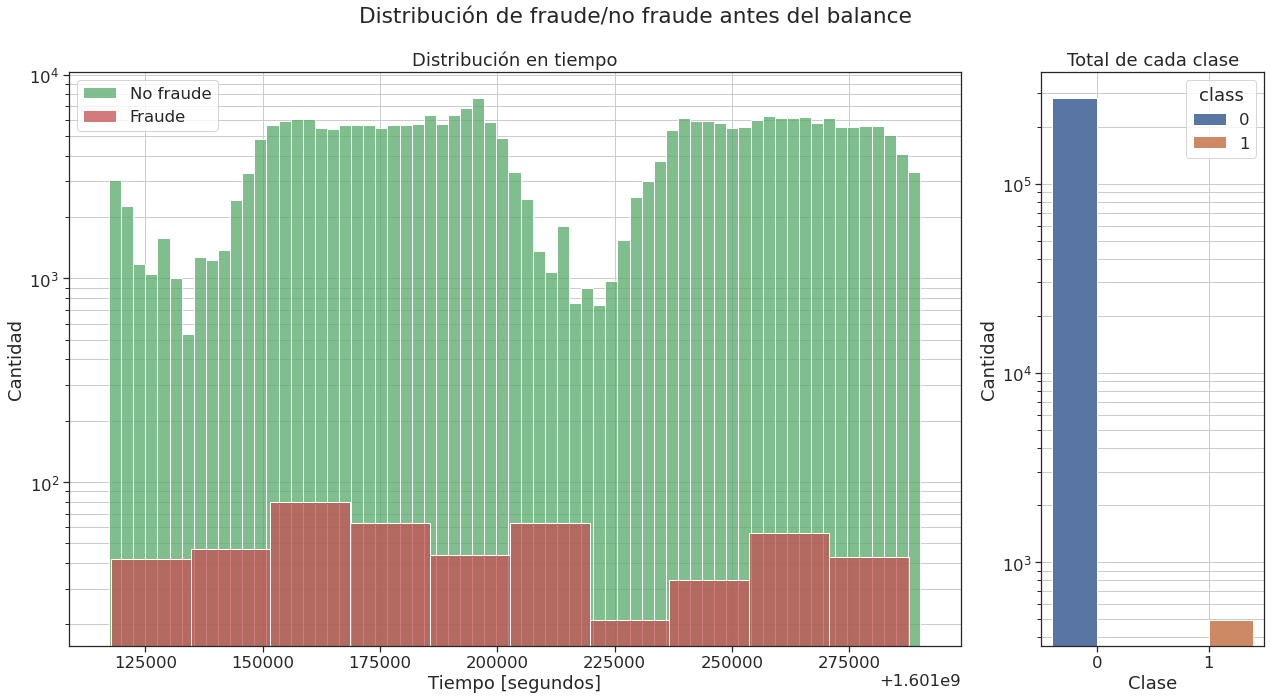

In [6]:
def plot_class_distribution(df, title,log=False):
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(18,10))
    
    plt.suptitle(title)
    
    # Time
    sns.histplot(df[df['class']==0]['time']-df.time.min()/1000, color='g', label='No fraude',ax=axes[0]) 
    sns.histplot(df[df['class']==1]['time']-df.time.min()/1000, color='r', label='Fraude',ax=axes[0]) 
    axes[0].grid(which="Both")
    axes[0].set_title("Distribución en tiempo")
    axes[0].legend(["No fraude","Fraude"])
    axes[0].set_xlabel("Tiempo [segundos]")
    axes[0].set_ylabel("Cantidad")   
    
    # Count
    sns.countplot(data=df,x="class", hue="class", ax=axes[1])  
    axes[1].set_title("Total de cada clase")
    axes[1].set_xlabel("Clase")
    axes[1].set_ylabel("Cantidad")   
    axes[1].grid(which="Both")
    
    if log:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    
    plt.tight_layout()
        
    print(df['class'].value_counts())
    
plot_class_distribution(df,title='Distribución de fraude/no fraude antes del balance',log=True)    

En este trabajo se procederá con las dos primeras técnicas (generando muestras sintéticas en el caso de upsampling) y en las sección del desarrollo y entrenamiento de modelos se propondrá una métrica apropiada.

### Downsampling

In [7]:
from sklearn.utils import resample

In [8]:
df_majority = df[df['class']==0]
df_minority = df[df['class']==1]

In [9]:
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123)

In [10]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['class'].value_counts()

1    492
0    492
Name: class, dtype: int64

1    492
0    492
Name: class, dtype: int64


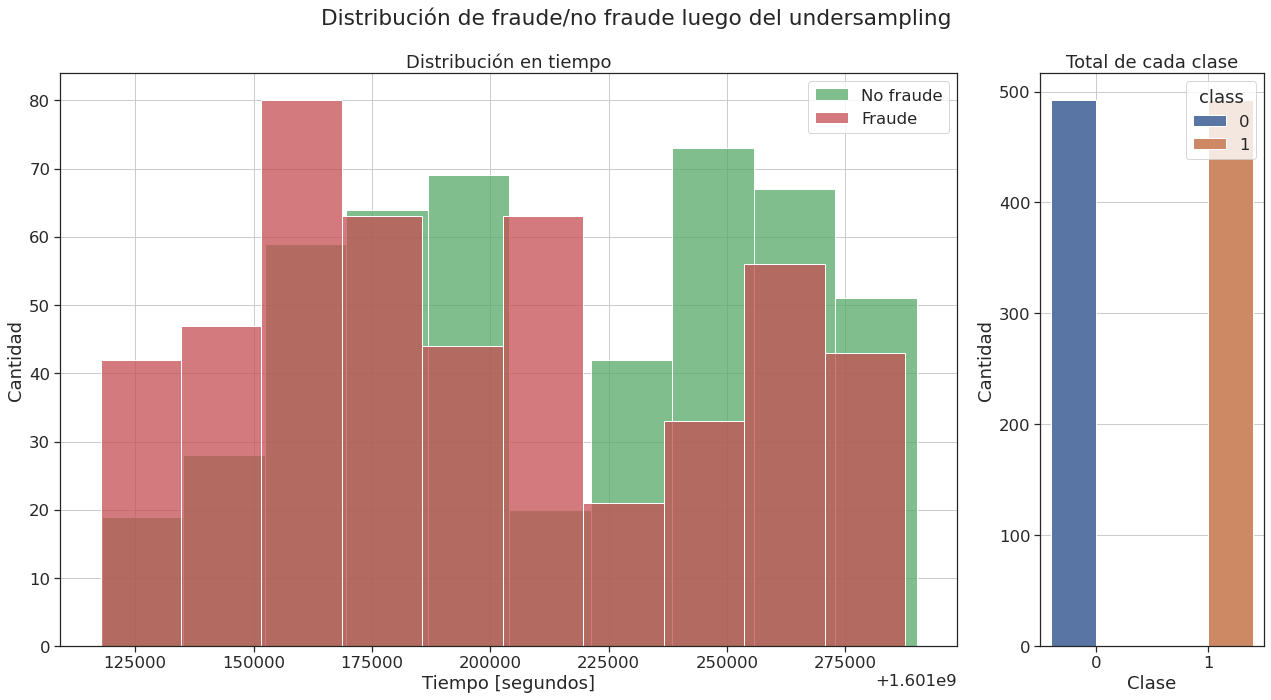

In [11]:
plot_class_distribution(df_downsampled,title='Distribución de fraude/no fraude luego del undersampling',log=False)

In [12]:
DATASET_DOWNSAMPLED_FILENAME_PATH = DATASET_PATH+"creditcard_downsampled.csv"
df_downsampled.to_csv(DATASET_DOWNSAMPLED_FILENAME_PATH)

### Upsampling

Como se introducirán muestras sintéticas es importante separar del dataset original la partición que se utilizará para la validación del modelo.

In [13]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.33

df_x =  df.drop(['class','row_id'], axis=1)
df_y =  df['class']

df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x,df_y, test_size=TEST_SIZE, random_state=42)
df_train = pd.concat([df_x_train,df_y_train],axis=1)
df_test = pd.concat([df_x_train,df_y_train],axis=1)

0    190477
1       343
Name: class, dtype: int64


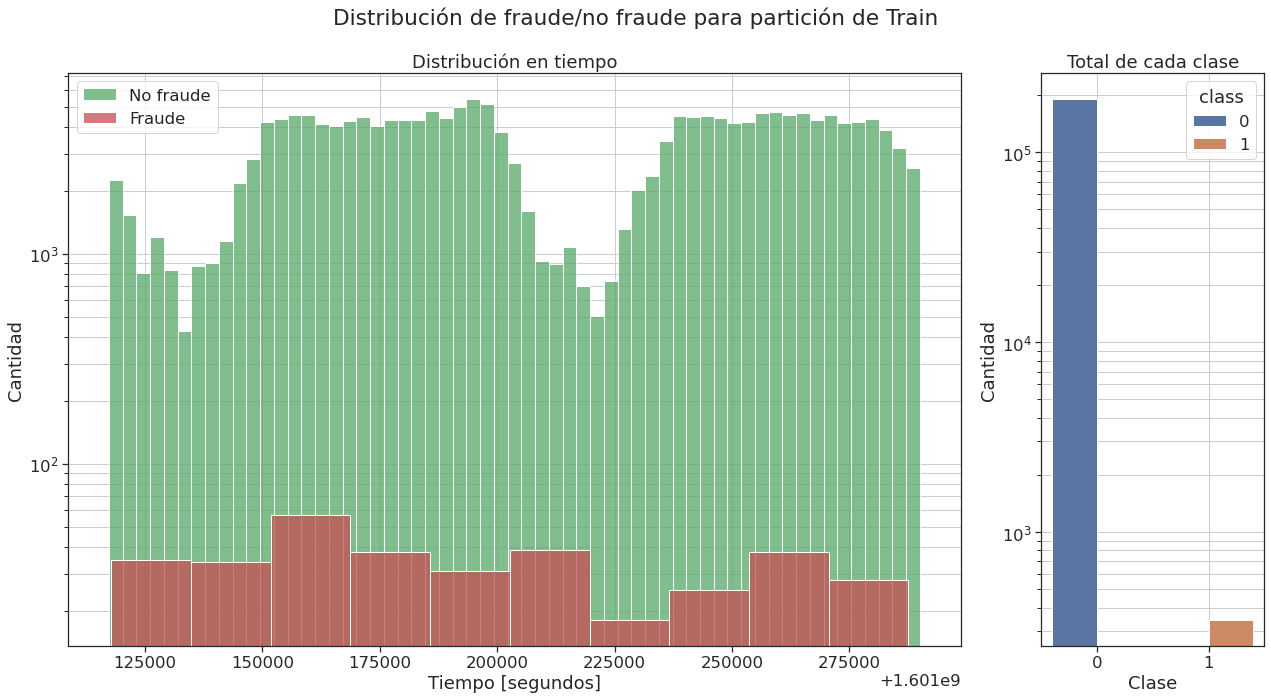

In [14]:
plot_class_distribution(df_train,title='Distribución de fraude/no fraude para partición de Train',log=True)

0    190477
1       343
Name: class, dtype: int64


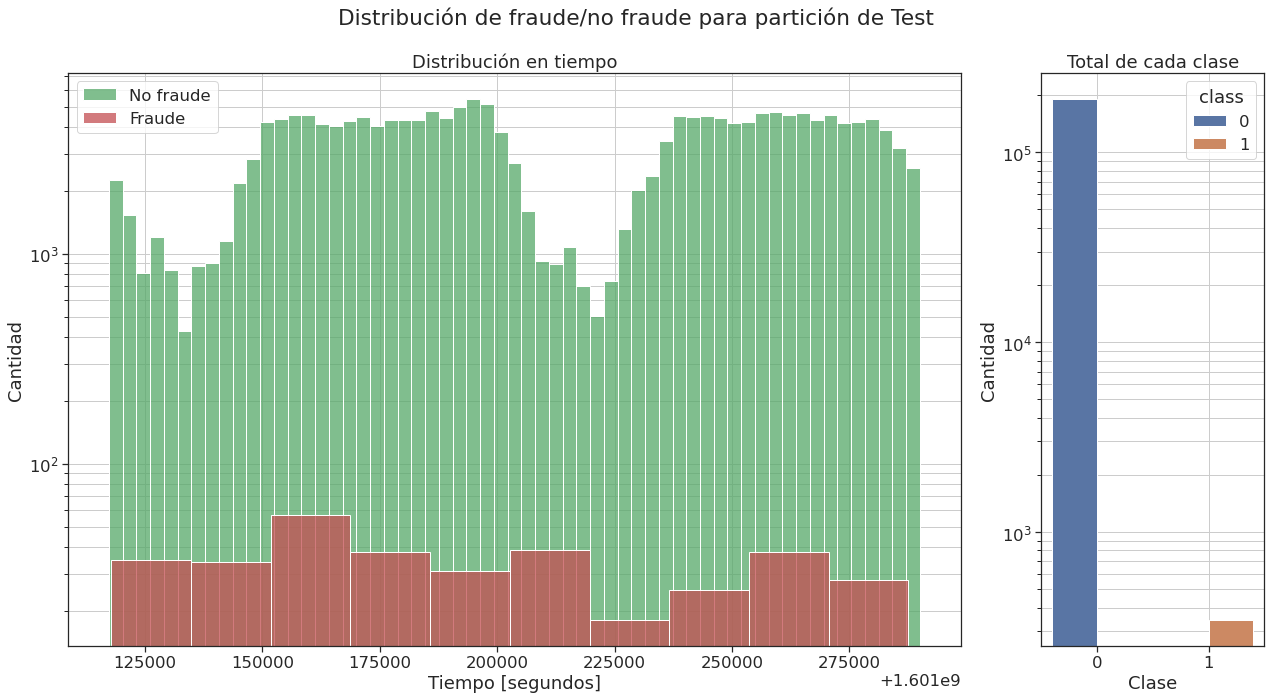

In [15]:
plot_class_distribution(df_test,title='Distribución de fraude/no fraude para partición de Test',log=True)

In [16]:
DATASET_SPLIT_TRAIN_FILENAME_PATH = DATASET_PATH+"creditcard_train.csv"
df_train.to_csv(DATASET_SPLIT_TRAIN_FILENAME_PATH)

In [17]:
DATASET_SPLIT_TEST_FILENAME_PATH = DATASET_PATH+"creditcard_test.csv"
df_test.to_csv(DATASET_SPLIT_TEST_FILENAME_PATH)

El agregado de muestras sintéticas se hará con la librería [imbalanced-learn](https://imbalanced-learn.org/stable/).

In [18]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

#### SMOTE

1    190477
0    190477
Name: class, dtype: int64


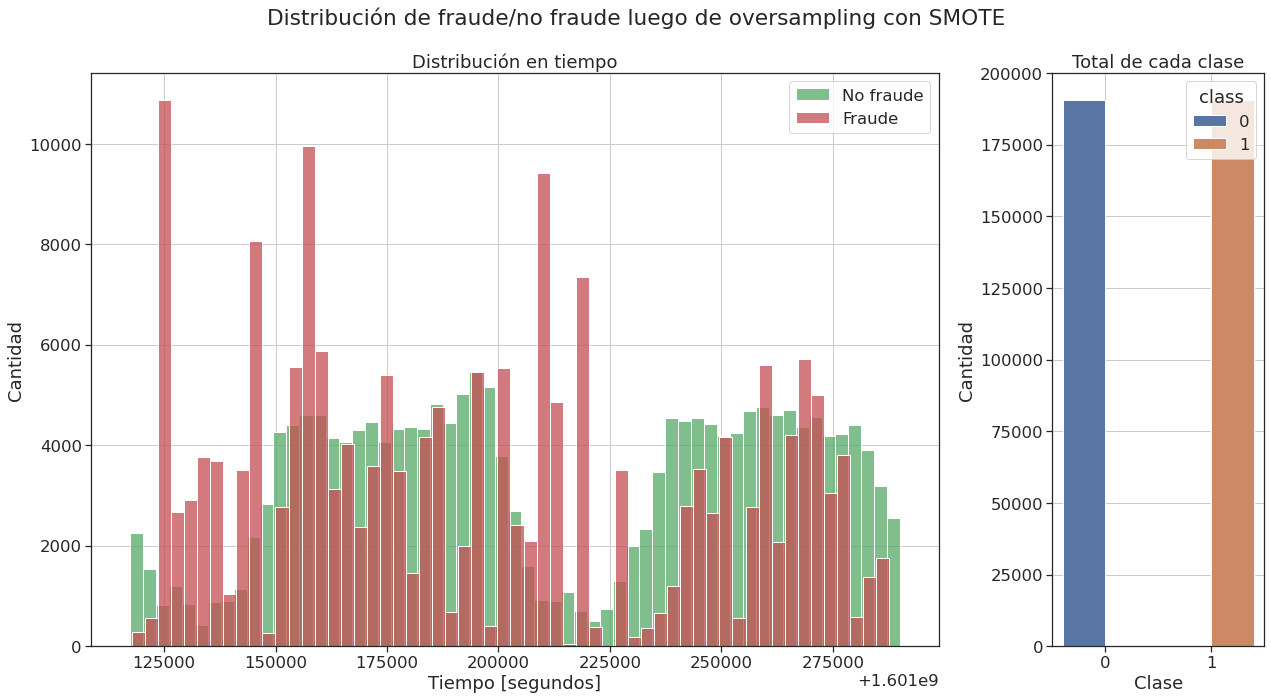

In [19]:
DATASET_TRAIN_OVERSAMPLED_SMOTE_FILENAME_PATH = DATASET_PATH+"creditcard_train_oversampled_smote.csv"
smote_oversampler = SMOTE()

df_x_train_resampled, df_y_train_resampled = smote_oversampler.fit_resample(df_x_train, df_y_train)
df_train_resampled = pd.concat([df_x_train_resampled,df_y_train_resampled],axis=1)
plot_class_distribution(df_train_resampled,title='Distribución de fraude/no fraude luego de oversampling con SMOTE',log=False)
df_train_resampled.to_csv(DATASET_TRAIN_OVERSAMPLED_SMOTE_FILENAME_PATH)

#### ADASYN

1    190496
0    190477
Name: class, dtype: int64


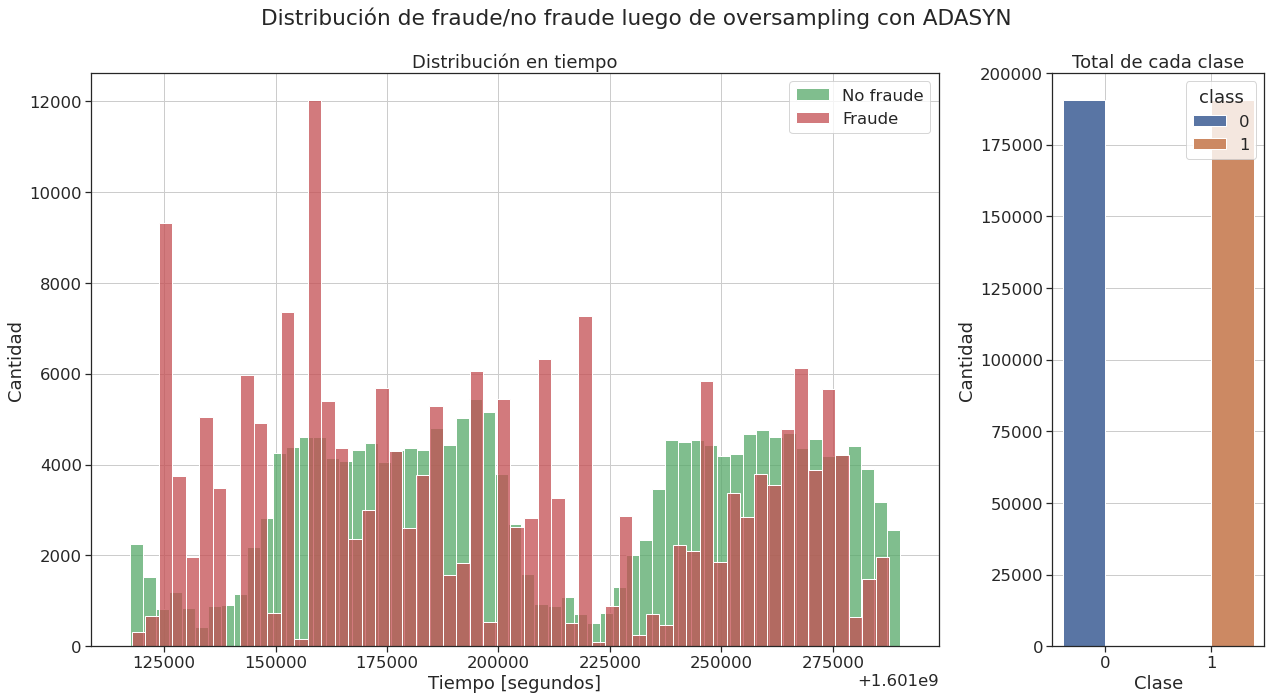

In [20]:
DATASET_TRAIN_OVERSAMPLED_ADASYN_FILENAME_PATH = DATASET_PATH+"creditcard_train_oversampled_adasyn.csv"
adasyn_oversampler = ADASYN()

df_x_train_resampled, df_y_train_resampled = adasyn_oversampler.fit_resample(df_x_train, df_y_train)
df_train_resampled = pd.concat([df_x_train_resampled,df_y_train_resampled],axis=1)
plot_class_distribution(df_train_resampled,title='Distribución de fraude/no fraude luego de oversampling con ADASYN',log=False)
df_train_resampled.to_csv(DATASET_TRAIN_OVERSAMPLED_ADASYN_FILENAME_PATH)

#### Borderline SMOTE

1    190477
0    190477
Name: class, dtype: int64


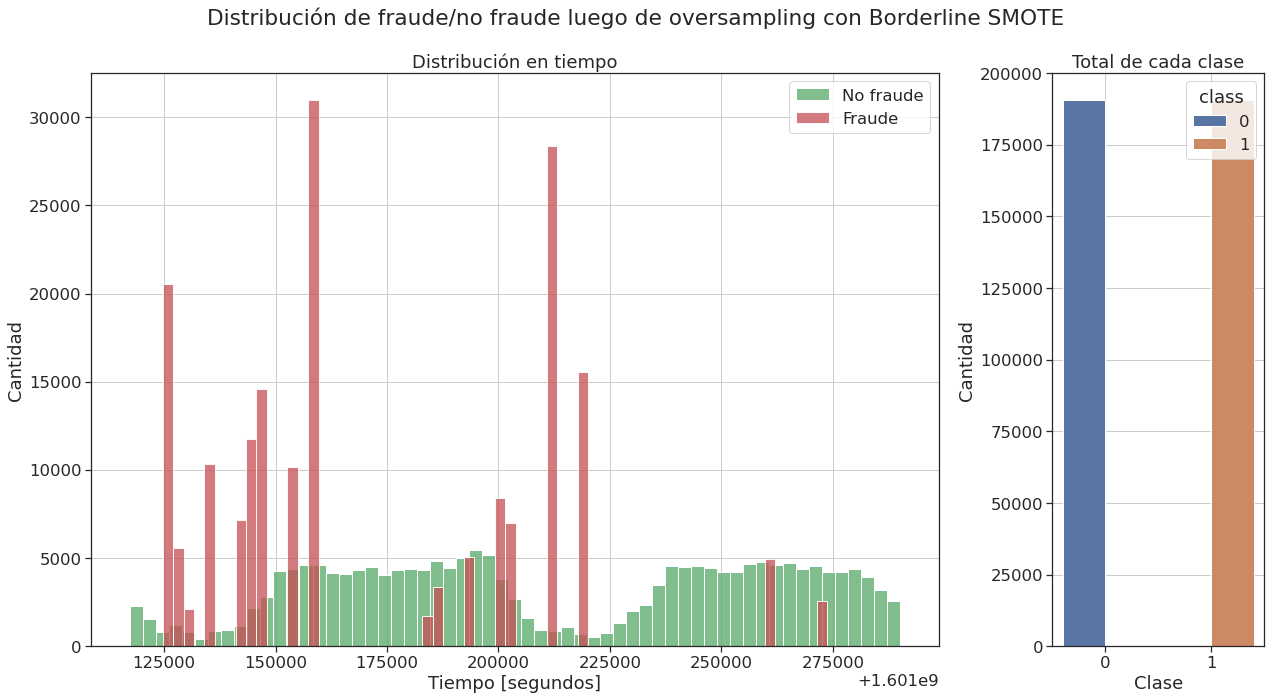

In [21]:
DATASET_TRAIN_OVERSAMPLED_BLSMOTE_FILENAME_PATH = DATASET_PATH+"creditcard_train_oversampled_blsmote.csv"
blsmote_oversampler = BorderlineSMOTE()

df_x_train_resampled, df_y_train_resampled = blsmote_oversampler.fit_resample(df_x_train, df_y_train)
df_train_resampled = pd.concat([df_x_train_resampled,df_y_train_resampled],axis=1)
plot_class_distribution(df_train_resampled,title='Distribución de fraude/no fraude luego de oversampling con Borderline SMOTE',log=False)
df_train_resampled.to_csv(DATASET_TRAIN_OVERSAMPLED_BLSMOTE_FILENAME_PATH)

In [22]:
DATASET_PATH

'/data/credit_fraud/'

In [24]:
!ls /data/credit_fraud/

creditcard.csv		    creditcard_train.csv
creditcard_downsampled.csv  creditcard_train_oversampled_adasyn.csv
creditcard_mod.csv	    creditcard_train_oversampled_blsmote.csv
creditcard.tar.xz	    creditcard_train_oversampled_smote.csv
creditcard_test.csv


- **creditcard.tar.xz/creditcard.csv**: dataset original.
- **creditcard_mod.csv**: dataset con agregado de columnas y row_id
- **creditcard_train.csv**: partición de dataset original para entrenamiento
- **creditcard_test.csv**: partición de dataset original para evaluación
- **creditcard_downsampled.csv**: dataset balanceado por downsampling.
- **creditcard_train_oversampled_smote.csv**: partición de entrenamiento balanceado por upsampling (SMOTE).
- **creditcard_train_oversampled_adasyn.csv**: partición de entrenamiento balanceado por upsampling (ADASYN).
- **creditcard_train_oversampled_blsmote.csv**: partición de entrenamiento balanceado por upsampling (Borderline SMOTE).